<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV

from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-12-27 22:13:40--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-12-27 22:13:41 (88.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [29]:
# function for plotting the confussion matrix
def plot_confusion_matrix(y,y_predict,label):
    "this function plots the confusion matrix"
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    title = 'Confusion Matrix '+ label
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    nameFig = 'ConfussionMaterix_Multivariate_RidgeRegression_'+label+'.png'
    #plt.savefig(nameFig)
    plt.show()
    plt.close()
    
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

In [6]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### Convert to date time object


In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [8]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [10]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



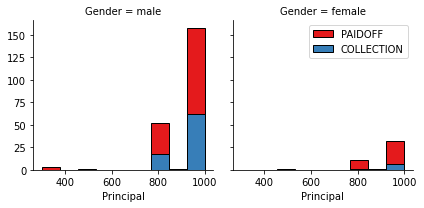

In [11]:
import seaborn as sns

# lets check the influence of gender
# sol: men ask for more loans than women and proportionally, men are more likelly to not pay off their debs
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10) # Number of containers: 10-1 = 9
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2) # number of subplots : col_wrap. 
#So if there are N categorical values in column col="Gender", the program will produce 2 plots only.
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

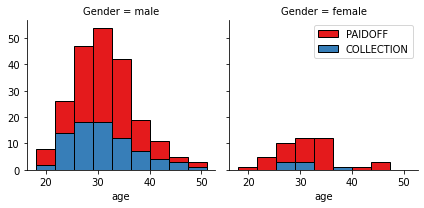

In [12]:
# lets check the age influence
# sol: youn men (around 30 years old) are more likely to not pay their debs
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


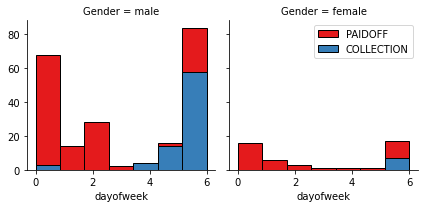

In [13]:
df['dayofweek'] = df['effective_date'].dt.dayofweek # this converts the date to a day of the week
#bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8) # The week has 7 days, so we only need 8 bins
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [14]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [22]:
# Working with integers
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
# working with categorical values
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

What are our lables?


In [23]:
# Working with integers
#df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
# working with categorical values
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])
df.head(100)

[[ 0.51578458  0.92071769  2.33152555 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769  0.34170148  2.37778177 -1.20577805  2.61985426
  -0.87997669 -0.86968108]
 [ 0.51578458 -0.95911111 -0.65321055 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.48739188  2.37778177  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.3215732  -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]]


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,116,116,1,1000,30,2016-09-11,2016-10-10,40,college,0,6,1
96,117,117,1,1000,30,2016-09-11,2016-10-10,23,High School or Below,0,6,1
97,118,118,1,1000,30,2016-09-11,2016-10-10,35,Bechalor,0,6,1
98,119,119,1,800,15,2016-09-11,2016-09-25,24,college,0,6,1


# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [26]:
# For this method I previouly tested various ratios when I slipt the data from train_loan.csv. For each test I also checked several values of the
# crossvalidation parameter and again, for each of these test I did a grid-search for finding the optimal imput parameters for the k-neighbours algorithm.
# I comented the steps for finding the best test size and crossvalidation values and I am just runnig the case that has the optimal values of such parameters

print("\n\n ******************** K-neighbours *******************")

from sklearn.neighbors import KNeighborsClassifier
    
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()
#
best_scheme_knn = np.zeros(6) # R^2 sore, K values, cv value
best_params_knn = []



 ******************** K-neighbours *******************


In [30]:
#for test_size_n in range(3,11):
for test_size_n in range(10,11):
    print("============== Test Sice: 1/",test_size_n)
    x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(7,8):
        print("--------- Cross Validation cv: ",cvn)

        knn_reg_cv = GridSearchCV(KNN,parameters,cv = cvn,return_train_score=True) # knn_reg_cv ???
        print("\n GridSearchCV")
        print(knn_reg_cv)
        #
        # lets fit the model to the training targets
        knn_reg_cv.fit(x_train_knn,y_train_knn)
        # lets fit the model to the training targets
        knn_reg_cv.fit(x_train_knn,y_train_knn)
        print("\n Estimalor List")
        print(knn_reg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(knn_reg_cv.best_estimator_)
        #
        # lets get the mean sccore in the cross-validation data
        scores = knn_reg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        # lets print out the score for the different free parameter values
        #print(scores)
        ##print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        print("tuned hpyerparameters :(best parameters) ",knn_reg_cv.best_params_)
        print("accuracy :",knn_reg_cv.best_score_)

        print("tuned hpyerparameters :(best parameters) ",knn_reg_cv.best_params_)
        print("accuracy with training data :",knn_reg_cv.best_score_)
        accuracy_knn = knn_reg_cv.best_score_
        print("accuracy :",accuracy_knn)
        #
        #
        yhat_knn_params =knn_reg_cv.predict(x_test_knn)
        yhat_train_knn_params = knn_reg_cv.predict(x_train_knn)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_knn = knn_reg_cv.score(x_train_knn,y_train_knn)
        print(trainingScore_knn)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_knn = knn_reg_cv.score(x_test_knn,y_test_knn)
        print(testScore_knn)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_knn_params,pos_label=2))
        #from sklearn.metrics import f1_score
        f1Val_knn = f1_score(y_test_knn, yhat_knn_params, average='weighted')
        print("f1_score: ",f1Val_knn)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_knn_params))
        #
        #if (best_scheme_knn[0]<accuracy_knn):
        if (best_scheme_knn[3]<f1Val_knn):
            best_scheme_knn = [accuracy_knn,trainingScore_knn,testScore_knn,f1Val_knn,test_size_n,cvn]
            best_params_knn = knn_reg_cv.best_estimator_
################################################## Plotting updatedd confussin matrix
            label = "logisticRegression_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
            plot_confusion_matrix(y_test_knn,yhat_knn_params,label)

============== Test Sice: 1/ 10
--------- Cross Validation cv:  7

 GridSearchCV
GridSearchCV(cv=7, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             return_train_score=True)

 Estimalor List
KNeighborsClassifier()

 lets find the best values for the free parameters
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)
tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2}
accuracy : 0.7360750360750361
tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2}
accuracy with training data : 0.7360750360750361
accuracy : 0.7360750360750361

 Lets calculate the R^2 for the training data set
0.797427652733119

 Lets calculate the R^2 for the testing data set
0.8571428571428571
f1_score:  0.8698669751301331


In [44]:
print("************************** GRID SEARCH RESULTS")
print("DECISION TREE Best score")
print(best_scheme_tree)
print("DECISION TREE Best parameters")
print(best_params_tree)

************************** GRID SEARCH RESULTS
DECISION TREE Best score
[0.7619492158327109, 0.7620578778135049, 0.7428571428571429, 0.7657605552342395, 10, 3]
DECISION TREE Best parameters
DecisionTreeClassifier(max_depth=8, max_features='auto', min_samples_leaf=4,
                       min_samples_split=5, splitter='random')


# Decision Tree


In [42]:
# For this method I previouly tested various ratios when I slipt the data from train_loan.csv. For each test I also checked several values of the
# crossvalidation parameter and again, for each of these test I did a grid-search for finding the optimal imput parameters for the Decision Tree algorithm.
# I comented the steps for finding the best test size and crossvalidation values and I am just runnig the case that has the optimal values of such parameters

print("\n\n ******************** DECISION TREE *******************")


from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
#
tree = DecisionTreeClassifier()
#
best_scheme_tree = np.zeros(6) # R^2 sore, K values, cv value
best_params_tree = []



 ******************** DECISION TREE *******************


============== Test Sice: 1/ 10
--------- Cross Validation cv:  3

 Estimalor List
DecisionTreeClassifier()

 lets find the best values for the free parameters
DecisionTreeClassifier(max_depth=8, max_features='auto', min_samples_leaf=4,
                       min_samples_split=5, splitter='random')
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.7619492158327109

 Lets calculate the R^2 for the training data set
0.7620578778135049

 Lets calculate the R^2 for the testing data set
0.7428571428571429
f1_score:  0.7657605552342395


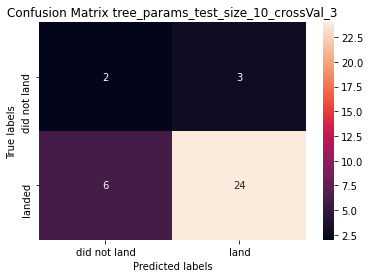

In [43]:
#for test_size_n in range(3,11):
for test_size_n in range(10,11):
    print("============== Test Sice: 1/",test_size_n)
    x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(3,4):
        print("--------- Cross Validation cv: ",cvn)
        treereg_cv = GridSearchCV(tree,parameters,cv = cvn,return_train_score=True)
        treereg_cv.fit(x_train_tree,y_train_tree)
        #
        print("\n Estimalor List")
        print(treereg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(treereg_cv.best_estimator_)
        #
        # lets get the mean sccore in the cross-validation data
        scores = treereg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        ### lets print out the score for the different free parameter values
        ###print(scores)
        ##print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        #
        print("tuned hpyerparameters :(best parameters) ",treereg_cv.best_params_)
        accuracy_tree = treereg_cv.best_score_
        print("accuracy :",accuracy_tree)
        #
        #
        yhat_tree_params =treereg_cv.predict(x_test_tree)
        yhat_train_tree_params = treereg_cv.predict(x_train_tree)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_tree = treereg_cv.score(x_train_tree,y_train_tree)
        print(trainingScore_tree)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_tree = treereg_cv.score(x_test_tree,y_test_tree)
        print(testScore_tree)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_tree_params,pos_label=2))
        #from sklearn.metrics import f1_score
        f1Val_tree = f1_score(y_test_tree, yhat_tree_params, average='weighted')
        print("f1_score: ",f1Val_tree)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_tree_params))
        #
        #if (best_scheme_tree[0]<accuracy_tree):
        if (best_scheme_tree[3]<f1Val_tree):
            best_scheme_tree = [accuracy_tree,trainingScore_tree,testScore_tree,f1Val_tree,test_size_n,cvn]
            best_params_tree = treereg_cv.best_estimator_
################################################## Plotting confussin matrix
        label = "tree_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
        plot_confusion_matrix(y_test_tree,yhat_tree_params,label)

In [47]:
print("************************** GRID SEARCH RESULTS")
print("DECISION TREE Best score")
print(best_scheme_tree)
print("DECISION TREE Best parameters")
print(best_params_tree)

************************** GRID SEARCH RESULTS
DECISION TREE Best score
[0.7619492158327109, 0.7620578778135049, 0.7428571428571429, 0.7657605552342395, 10, 3]
DECISION TREE Best parameters
DecisionTreeClassifier(max_depth=8, max_features='auto', min_samples_leaf=4,
                       min_samples_split=5, splitter='random')


# Support Vector Machine


In [49]:
# For this method I previouly tested various ratios when I slipt the data from train_loan.csv. For each test I also checked several values of the
# crossvalidation parameter and again, for each of these test I did a grid-search for finding the optimal imput parameters for the Support Vector Machine algorithm.
# I comented the steps for finding the best test size and crossvalidation values and I am just runnig the case that has the optimal values of such parameters

print("\n\n ******************** SUPPORT VECTOR MACHINE *******************")
from sklearn.svm import SVC
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
#
best_scheme_svm = np.zeros(6) # R^2 sore, K values, cv value
best_params_svm = []



 ******************** SUPPORT VECTOR MACHINE *******************


============== Test Sice: 1/ 10
--------- Cross Validation cv:  7

 GridSearchCV
GridSearchCV(cv=7, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('rbf', 'sigmoid')},
             return_train_score=True)

 Estimalor List
SVC()

 lets find the best values for the free parameters
SVC(gamma=31.622776601683793)

 lets print out the score for the different free parameter values
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 31.622776601683793, 'kernel': 'rbf'}
accuracy with training data : 0.7396103896103897
accuracy : 0.7396103896103897

 Lets calculate the R^2 for the training data set
0.8713826366559485

 Lets calculate the R^2 for the testing data set
0.8
f1_score:  0.8073959938366718


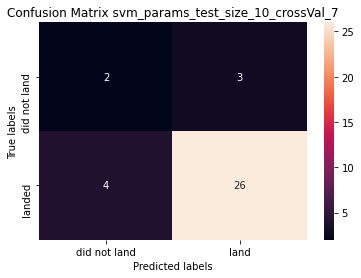

In [50]:
#for test_size_n in range(3,11):
for test_size_n in range(10,11):
    print("============== Test Sice: 1/",test_size_n)
    x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(7,8):
        print("--------- Cross Validation cv: ",cvn)
        svmreg_cv = GridSearchCV(svm,{'kernel':('rbf', 'sigmoid'),'C': np.logspace(-3, 3, 5),'gamma':np.logspace(-3, 3, 5)},cv = cvn,return_train_score=True)
        print("\n GridSearchCV")
        print(svmreg_cv)
        # lets fit the model to the training targets
        svmreg_cv.fit(x_train_svm,y_train_svm)
        print("\n Estimalor List")
        print(svmreg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(svmreg_cv.best_estimator_)
        #
        #
        # lets get the mean sccore in the cross-validation data
        scores = svmreg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        ### lets print out the score for the different free parameter values
        ###print(scores)
        print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        print("tuned hpyerparameters :(best parameters) ",svmreg_cv.best_params_)
        print("accuracy with training data :",svmreg_cv.best_score_)
        accuracy_svm = svmreg_cv.best_score_
        print("accuracy :",accuracy_svm)
        #
        #
        yhat_svm_params =svmreg_cv.predict(x_test_svm)
        yhat_train_svm_params = svmreg_cv.predict(x_train_svm)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_svm = svmreg_cv.score(x_train_svm,y_train_svm)
        print(trainingScore_svm)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_svm = svmreg_cv.score(x_test_svm,y_test_svm)
        print(testScore_svm)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_svm_params,pos_label=2))
        #from sklearn.metrics import f1_score
        f1Val_svm = f1_score(y_test_svm, yhat_svm_params, average='weighted')
        print("f1_score: ",f1Val_svm)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_svm_params))
        #
        #if (best_scheme_svm[0]<accuracy_svm):
        if (best_scheme_svm[3]<f1Val_svm):
            best_scheme_svm = [accuracy_svm,trainingScore_svm,testScore_svm,f1Val_svm,test_size_n,cvn]
            best_params_svm = svmreg_cv.best_estimator_
################################################## Plotting confussin matrix
        label = "svm_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
        plot_confusion_matrix(y_test_svm,yhat_svm_params,label)

In [51]:
print("************************** GRID SEARCH RESULTS")
print("SUPPORT VECTOR MACHINE Best score")
print(best_scheme_svm)
print("SUPPORT VECTOR MACHINE Best parameters")
print(best_params_svm)

************************** GRID SEARCH RESULTS
SUPPORT VECTOR MACHINE Best score
[0.7396103896103897, 0.8713826366559485, 0.8, 0.8073959938366718, 10, 7]
SUPPORT VECTOR MACHINE Best parameters
SVC(gamma=31.622776601683793)


# Logistic Regression


In [52]:
# For this method I previouly tested various ratios when I slipt the data from train_loan.csv. For each test I also checked several values of the
# crossvalidation parameter and again, for each of these test I did a grid-search for finding the optimal imput parameters for the Logistic Regression algorithm.
# I comented the steps for finding the best test size and crossvalidation values and I am just runnig the case that has the optimal values of such parameters

print("\n\n ******************** Logistic Regression *******************")
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
#
best_scheme_lr = np.zeros(6) # R^2 sore, K values, cv value
best_params_lr = []




 ******************** Logistic Regression *******************


============== Test Sice: 1/ 10
--------- Cross Validation cv:  3

 GridSearchCV
GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             return_train_score=True)

 Estimalor List
LogisticRegression()

 lets find the best values for the free parameters
LogisticRegression(C=0.01)
tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.739544436146378
tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy with training data : 0.739544436146378
accuracy : 0.739544436146378

 Lets calculate the R^2 for the training data set
0.7395498392282959

 Lets calculate the R^2 for the testing data set
0.8571428571428571
f1_score:  0.7912087912087912


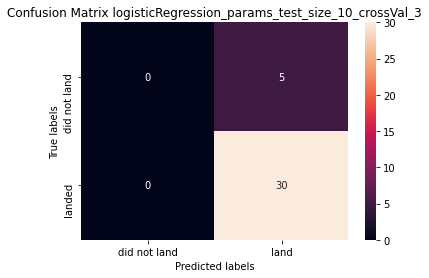

In [53]:
#for test_size_n in range(3,11):
for test_size_n in range(10,11):
    print("============== Test Sice: 1/",test_size_n)
    x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(3,4):
        print("--------- Cross Validation cv: ",cvn)

        logreg_cv = GridSearchCV(lr,parameters,cv = cvn,return_train_score=True) # logreg_cv ???
        print("\n GridSearchCV")
        print(logreg_cv)
        #
        # lets fit the model to the training targets
        logreg_cv.fit(x_train_lr,y_train_lr)
        # lets fit the model to the training targets
        logreg_cv.fit(x_train_lr,y_train_lr)
        print("\n Estimalor List")
        print(logreg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(logreg_cv.best_estimator_)
        #
        # lets get the mean sccore in the cross-validation data
        scores = logreg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        # lets print out the score for the different free parameter values
        #print(scores)
        ##print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
        print("accuracy :",logreg_cv.best_score_)

        print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
        print("accuracy with training data :",logreg_cv.best_score_)
        accuracy_lr = logreg_cv.best_score_
        print("accuracy :",accuracy_lr)
        #
        #
        yhat_lr_params =logreg_cv.predict(x_test_lr)
        yhat_train_lr_params = logreg_cv.predict(x_train_lr)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_lr = logreg_cv.score(x_train_lr,y_train_lr)
        print(trainingScore_lr)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_lr = logreg_cv.score(x_test_lr,y_test_lr)
        print(testScore_lr)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_lr_params,pos_label=2))
        #from sklearn.metrics import f1_score
        f1Val_lr = f1_score(y_test_lr, yhat_lr_params, average='weighted')
        print("f1_score: ",f1Val_lr)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_lr_params))
        #
        #if (best_scheme_lr[0]<accuracy_lr):
        if (best_scheme_lr[3]<f1Val_lr):
            best_scheme_lr = [accuracy_lr,trainingScore_lr,testScore_lr,f1Val_lr,test_size_n,cvn]
            best_params_lr = logreg_cv.best_estimator_
################################################## Plotting confussin matrix
        label = "logisticRegression_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
        plot_confusion_matrix(y_test_lr,yhat_lr_params,label)
        #

In [54]:
print("************************** GRID SEARCH RESULTS")
print("Logistic Regression Best score")
print(best_scheme_lr)
print("Logistic Regression Best parameters")
print(best_params_lr)

************************** GRID SEARCH RESULTS
Logistic Regression Best score
[0.739544436146378, 0.7395498392282959, 0.8571428571428571, 0.7912087912087912, 10, 3]
Logistic Regression Best parameters
LogisticRegression(C=0.01)


# Model Evaluation using Test set


In [55]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [56]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-12-27 22:40:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-12-27 22:40:33 (31.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [57]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [58]:
# data pre-processing 
test_df.shape

test_df.dtypes

#convert to date-time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

test_df.dtypes


# Data visualiztion and pre-processing
test_df['loan_status'].value_counts()

### notice: installing seaborn might takes a few minutes
##!conda install -c anaconda seaborn -y


# Feature selection/extraction

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek # this converts the date to a day of the week
#bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()


test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

test_df[['Principal','terms','age','Gender','education']].head()
print(test_df.shape)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

print(Feature.shape)
X_test = Feature
#X_test[0:5]

X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
print(len(X_test))
test_df.head()

# Working with integers
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
# working with categorical values
y_test = test_df['loan_status'].values
#y_test[0:5]
print(len(y_test))

(54, 12)
(54, 8)
54
54


In [71]:
# k-neighbours prediction
print("================ k-neighbours prediction")
yhat_testknn_params =knn_reg_cv.predict(X_test)
#
print("\n Lets calculate the R^2 for the testing data set")
testScore_knn = knn_reg_cv.score(X_test,y_test)
print(testScore_knn)
#
from sklearn.metrics import jaccard_score
#print("jaccard_score: ",jaccard_score(y_test, yhat_testlr_params,pos_label=2))
print("jaccard_score: ",jaccard_score(y_test, yhat_testknn_params))
#from sklearn.metrics import f1_score
f1Val_knn = f1_score(y_test, yhat_testknn_params, average='weighted')
print("f1_score: ",f1Val_knn)
#from sklearn.metrics import log_loss
##print("log_loss score: ",log_loss(y_test, yhat_testknn_params))

================ k-neighbours prediction

 Lets calculate the R^2 for the testing data set
0.7222222222222222
jaccard_score:  0.6938775510204082
f1_score:  0.7105756358768406


In [67]:
# Decision tree prediction
print("================ Decision tree prediction")
yhat_testtree_params =treereg_cv.predict(X_test)
#
print("\n Lets calculate the R^2 for the testing data set")
testScore_tree = treereg_cv.score(X_test,y_test)
print(testScore_tree)
#
#from sklearn.metrics import jaccard_score
print("jaccard_score: ",jaccard_score(y_test, yhat_testtree_params))
#from sklearn.metrics import f1_score
f1Val_tree = f1_score(y_test, yhat_testtree_params, average='weighted')
print("f1_score: ",f1Val_tree)
#from sklearn.metrics import log_loss
##print("log_loss score: ",log_loss(y_test, yhat_testtree_params))

================ Decision tree prediction

 Lets calculate the R^2 for the testing data set
0.7777777777777778
jaccard_score:  0.76
f1_score:  0.7434343434343433


In [68]:
# SVM prediction
print("================ SVM prediction")
yhat_testsvm_params =svmreg_cv.predict(X_test)
#
print("\n Lets calculate the R^2 for the testing data set")
testScore_svm = svmreg_cv.score(X_test,y_test)
print(testScore_svm)
#
#from sklearn.metrics import jaccard_score
print("jaccard_score: ",jaccard_score(y_test, yhat_testsvm_params))
#from sklearn.metrics import f1_score
f1Val_svm = f1_score(y_test, yhat_testsvm_params, average='weighted')
print("f1_score: ",f1Val_svm)
#from sklearn.metrics import log_loss
##print("log_loss score: ",log_loss(y_test, yhat_testsvm_params))

================ SVM prediction

 Lets calculate the R^2 for the testing data set
0.7222222222222222
jaccard_score:  0.7222222222222222
f1_score:  0.6212664277180406


In [70]:
# logistic regresion prediction
print("================ logistic regresion prediction")
yhat_testlr_params =logreg_cv.predict(X_test)
#
print("\n Lets calculate the R^2 for the testing data set")
testScore_lr = logreg_cv.score(X_test,y_test)
print(testScore_lr)
#
#from sklearn.metrics import jaccard_score
print("jaccard_score: ",jaccard_score(y_test, yhat_testlr_params))
#from sklearn.metrics import f1_score
f1Val_lr = f1_score(y_test, yhat_testlr_params, average='weighted')
print("f1_score: ",f1Val_lr)
#from sklearn.metrics import log_loss
print("log_loss score: ",log_loss(y_test, yhat_testlr_params))

================ logistic regresion prediction

 Lets calculate the R^2 for the testing data set
0.7407407407407407
jaccard_score:  0.7407407407407407
f1_score:  0.6304176516942475
log_loss score:  8.95470488690319


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard    | F1-score    | LogLoss |
| ------------------ | -------    | --------    | ------- |
| KNN                | 0.69       | 0.71        | NA      |
| Decision Tree      | 0.78       | 0.77        | NA      |
| SVM                | 0.72       | 0.32        | NA      |
| LogisticRegression | 0.74       | 0.63        | 8.95       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
